<a href="https://colab.research.google.com/github/Claptar/spatialMPFC/blob/main/Fanctional_analysis/pseudobulk/EdgeR_Functional_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies and files

## Install dependencies

In [2]:
!pip install scanpy[leiden] anndata2ri scikit-misc scvi-tools squidpy gseapy sc-toolbox decoupler --quiet

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 KB 1.8 MB/s eta 0:00:00


## Imports

In [3]:
import warnings
import scanpy as sc
import gseapy
import decoupler
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

Нужно подключить свой гугл диск

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_path = 'drive/MyDrive/Spatial project/results/'

In [6]:
de_dir_path = 'drive/MyDrive/Spatial project/results/DE/young_vs_old_scanpy/'

In [7]:
os.listdir(de_dir_path)

['edgeR', 'scanpy']

### DE results

In [8]:
# Load EdgeR results
edgeR_DE = dict()

for file in os.listdir(de_dir_path + 'edgeR'):
    layer = file.split('_')[0]
    df = pd.read_csv(de_dir_path + 'edgeR/' + file, index_col=0)
    # remove mito hb and rb genes
    mito = df.index.str.startswith('MT-')
    hb = df.index.str.contains(("^HB[AB]"))
    rb = df.index.str.contains(("^RP[LS]"))
    remove = mito | hb | rb
    df = df.loc[~remove]
    
    edgeR_DE[layer] = df

edgeR_DE.keys()

dict_keys(['WM', 'L5', 'L2', 'L3', 'L1', 'L6', 'L4'])

In [9]:
edgeR_DE['L1']

logFC     logCPM             F        PValue           FDR
NLRP1    -12.290117   7.616894  8.849669e+02  4.300965e-52  5.082880e-48
DPYSL3     3.618613   8.494822  6.061350e+02  1.164502e-45  6.881043e-42
VXN      -11.139452   6.644319  5.611696e+02  2.859678e-43  1.126522e-39
YBX1       3.958872   8.784563  5.298523e+02  4.782240e-43  1.412913e-39
TUBA1A     3.208877  11.739539  4.999432e+02  6.182635e-42  1.461328e-38
...             ...        ...           ...           ...           ...
HUS1       0.000509   3.249055  1.254909e-06  9.991083e-01  9.992944e-01
TUBGCP2    0.013668   5.847461  9.082083e-03  9.991178e-01  9.992944e-01
UBE2G2     0.000170   5.152333  9.525497e-07  9.992231e-01  9.992944e-01
PGS1       0.059686   4.460213  7.521595e-02  9.992876e-01  9.992944e-01
FAM114A2   0.000340   3.383864  7.857817e-07  9.992944e-01  9.992944e-01

[11707 rows x 5 columns]

### Load adata

In [10]:
# read young human adata object
human_young = sc.read_h5ad(dir_path + 'filtered_samples/human.h5ad')
print(human_young)

# add _young sufix to layer name
human_young.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
human_young.obs.label = human_young.obs.label.astype('str') + '_young'

AnnData object with n_obs × n_vars = 15417 × 19966
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_pct_counts_ribo_colors', 'qc_total_counts_colors', 'spatial'
    obsm: 'spatial'


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
# read young human adata object
human_old = sc.read_h5ad(dir_path + 'filtered_samples/spatial_libd_human.h5ad')
print(human_old)

# add _young sufix to layer name
human_old.obs.label = human_old.obs.label.astype('str') + '_old'

AnnData object with n_obs × n_vars = 42588 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_pct_counts_mt_colors', 'qc_pct_counts_ribo_colors', 'qc_total_counts_colors', 'spatial'
    obsm: 'spatial'


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
# concat old and young files
adata = an.concat([human_young, human_old], merge='same',uns_merge="unique")
adata.obs_names_make_unique()
adata

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 58005 × 19404
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_total_counts_colors', 'spatial', 'qc_pct_counts_mt_colors'
    obsm: 'spatial'

In [13]:
samples = list(adata.uns['spatial'].keys())
samples

['human_759',
 'human_j12',
 'human_j3',
 'human_j4',
 'human_j6',
 '151507',
 '151508',
 '151509',
 '151510',
 '151669',
 '151670',
 '151671',
 '151672',
 '151673',
 '151674',
 '151675',
 '151676']

In [14]:
del human_young, human_old

### Load pseudobulks

In [24]:
de_dir_path = 'drive/MyDrive/Spatial project/results/DE/pseudobulks/'

In [25]:
os.listdir(de_dir_path)

['expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_mean_chimp.csv',
 'annotation_chimp.csv',
 'expression_sum_human.csv',
 'expression_mean_human.csv',
 'annotation_human.csv',
 'expression_sum_macaque.csv',
 'expression_mean_macaque.csv',
 'annotation_macaque.csv',
 'expression_sum_spatial_libd_human.csv',
 'expression_mean_spatial_libd_human.csv',
 'annotation_spatial_libd_human.csv']

In [43]:
adata_pb_list = list()
aggregate_method = 'mean'

for library in ['human', 'spatial_libd_human']:
    exp_file_name = '_'.join(['expression', aggregate_method, library]) + '.csv'
    ann_file_name = '_'.join(['annotation', library]) + '.csv'
    expr_file = pd.read_csv(de_dir_path + exp_file_name, index_col=0)
    ann_file = pd.read_csv(de_dir_path + ann_file_name, index_col=0)
    adata_pb = an.AnnData(expr_file.T, obs=ann_file)
    adata_pb_list.append(adata_pb)

In [45]:
adata_pb = an.concat(adata_pb_list, merge='same')
adata_pb

AnnData object with n_obs × n_vars = 111 × 19404
    obs: 'layer', 'sample_id', 'condition'

### Preprocess pseudobulk

In [46]:
# preprocess
adata_pb.raw = adata_pb
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [61]:
adata_pb.obs.sample_id = adata_pb.obs.sample_id.astype('category')
adata_pb.obs['label'] = adata_pb.obs.layer.astype(str)  + adata_pb.obs.condition.astype(str).replace({"human": '_young', "spatial_libd_human": '_old'})

/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [52]:
sc.pp.highly_variable_genes(
    adata=adata_pb, flavor="seurat", 
    n_top_genes=4000, inplace=True,
    batch_key="sample_id")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [53]:
mito = adata_pb.var_names.str.startswith('MT-')
hb = adata_pb.var_names.str.contains(("^HB[AB]"))
rb = adata_pb.var_names.str.contains(("^RP[LS]"))
remove = mito | hb | rb
genes_to_remove = adata_pb.var_names[remove].tolist()

keep = np.invert(remove)
print(sum(remove))

adata_pb = adata_pb[:,keep]
highly_variable_genes_pb = adata_pb.var[adata_pb.var.highly_variable].index.tolist()

117


### Add diff. expr. results to adata

In [37]:
from sc_toolbox.tools import de_res_to_anndata

for layer in edgeR_DE.keys():
    label = layer + '_young'
    df = edgeR_DE[layer]
    df["gene_symbol"] = df.index
    df["label"] = label


    de_res_to_anndata(
            adata,
            df,
            groupby="label",
            score_col="logCPM",
            pval_col="PValue",
            pval_adj_col="FDR",
            lfc_col="logFC",
            key_added="edgeR_" + label,
        )

In [62]:
from sc_toolbox.tools import de_res_to_anndata

for layer in edgeR_DE.keys():
    label = layer + '_young'
    df = edgeR_DE[layer]
    df["gene_symbol"] = df.index
    df["label"] = label


    de_res_to_anndata(
            adata_pb,
            df,
            groupby="label",
            score_col="logCPM",
            pval_col="PValue",
            pval_adj_col="FDR",
            lfc_col="logFC",
            key_added="edgeR_" + label,
        )

### Preprocess

In [63]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [64]:
sc.pp.highly_variable_genes(
    adata=adata, flavor="seurat", 
    n_top_genes=4000, inplace=True,
    batch_key="sample_id")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:25)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [65]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:44)


In [66]:
mito = adata.var_names.str.startswith('MT-')
hb = adata.var_names.str.contains(("^HB[AB]"))
rb = adata.var_names.str.contains(("^RP[LS]"))
remove = mito | hb | rb
genes_to_remove = adata.var_names[remove].tolist()

keep = np.invert(remove)
print(sum(remove))

de_adata = adata[:,keep]
highly_variable_genes = adata.var[adata.var.highly_variable].index.tolist()

117


# Результаты дифф. экспрессии

In [71]:
def sign_de(de_results):
    sign_dict = dict()
    
    for layer, df in de_results.items():
        sign_dict[layer] = df[df.PValue < 0.05]
    return sign_dict

In [73]:
edgeR_sign = sign_de(edgeR_DE)

In [74]:
common_degenes = edgeR_sign['L1'].index & edgeR_sign['L2'].index & edgeR_sign['L3'].index &\
                 edgeR_sign['L4'].index & edgeR_sign['L5'].index & edgeR_sign['L6'].index & edgeR_sign['WM'].index
common_degenes

Index(['NLRP1', 'DPYSL3', 'VXN', 'YBX1', 'TUBA1A', 'STMN2', 'PTP4A1', 'CXADR',
       'IDS', 'KCNAB2',
       ...
       'PLK3', 'AP3M1', 'OMG', 'ABCC5', 'SLC35A1', 'PREX2', 'ATF3', 'SMARCA2',
       'SDR39U1', 'SENP1'],
      dtype='object', length=4396)

### Отберем гены, которые являются дифф. экспр. во всех слоях и встречаются в более чем половине спотов образцов

In [80]:
def calculate_pct_group(adata, group):
    for value in adata.obs[group].unique():
        mask = (adata.obs[group] == value)
        value_pct = adata[mask].X.getnnz(axis=0) / adata[mask].X.shape[0]
        adata.var["pct_" + value] = value_pct

In [81]:
calculate_pct_group(adata, 'sample_id')
calculate_pct_group(adata, 'label')
adata.var.head()

feature_types     mt     hb   ribo  highly_variable     means  \
OR4F5   Gene Expression  False  False  False            False  0.000000   
OR4F29  Gene Expression  False  False  False            False  0.000000   
OR4F16  Gene Expression  False  False  False            False  0.000000   
SAMD11  Gene Expression  False  False  False             True  0.028024   
NOC2L   Gene Expression  False  False  False            False  0.532642   

        dispersions  dispersions_norm  highly_variable_nbatches  \
OR4F5      0.000000          0.000000                         0   
OR4F29     0.000000          0.000000                         0   
OR4F16     0.000000          0.000000                         0   
SAMD11     1.876917          0.800700                        10   
NOC2L      1.566706         -0.535989                         0   

        highly_variable_intersection  ...  pct_L1_young  pct_L6_young  \
OR4F5                          False  ...      0.000000      0.000000   
OR4F29                         False  ...      0.000000      0.000000   
OR4F16                         False  ...      0.000000      0.000000   
SAMD11                         False  ...      0.012186      0.003392   
NOC2L                          False  ...      0.123382      0.254381   

        pct_L4_young  pct_L1_old  pct_L3_old  pct_WM_old  pct_L6_old  \
OR4F5       0.000000    0.000000    0.000000    0.000000    0.000000   
OR4F29      0.000000    0.000000    0.000000    0.000000    0.000000   
OR4F16      0.000000    0.000000    0.000000    0.000000    0.000000   
SAMD11      0.007692    0.006058    0.004150    0.013336    0.006702   
NOC2L       0.458242    0.061662    0.145442    0.095884    0.150302   

        pct_L5_old  pct_L2_old  pct_L4_old  
OR4F5     0.000000    0.000000    0.000000  
OR4F29    0.000000    0.000000    0.000000  
OR4F16    0.000000    0.000000    0.000000  
SAMD11    0.005294    0.002559    0.004961  
NOC2L     0.178996    0.144424    0.167442  

[5 rows x 41 columns]

In [78]:
common_hv_genes = set(highly_variable_genes) & set(common_degenes)
len(common_hv_genes)

1119

In [82]:
columns = adata.var.columns
sample_id_pct_columns = columns[(columns.str.contains("pct")) & (~columns.str.contains("L"))]
layer_pct_columns = columns[columns.str.contains("L")]

In [83]:
mask = (adata.var[sample_id_pct_columns].min(axis=1) > 0.1)
common_highpct_genes = adata.var.loc[common_degenes][mask].index
common_highpct_genes

<ipython-input-83-33c0e496f983>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_highpct_genes = adata.var.loc[common_degenes][mask].index


Index(['YBX1', 'TUBA1A', 'STMN2', 'STMN1', 'TUBB2B', 'NNAT', 'TUBB', 'CA11',
       'CKB', 'CRMP1',
       ...
       'ESD', 'WIPI2', 'NDRG1', 'DDB1', 'LIMCH1', 'PTPRF', 'HMGA1', 'OLIG1',
       'OMG', 'SMARCA2'],
      dtype='object', length=843)

In [93]:
de_df = edgeR_sign['L1']
upreg_genes = de_df.loc[common_highpct_genes][de_df.logFC > 0].index.tolist()
dwreg_genes = de_df.loc[common_highpct_genes][de_df.logFC < 0].index.tolist()
print(f'upreg: {len(upreg_genes)}')
print(f'dwreg: {len(dwreg_genes)}')

upreg: 420
dwreg: 423


<ipython-input-93-c3fa17a81de7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  upreg_genes = de_df.loc[common_highpct_genes][de_df.logFC > 0].index.tolist()
<ipython-input-93-c3fa17a81de7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dwreg_genes = de_df.loc[common_highpct_genes][de_df.logFC < 0].index.tolist()


# GSA

In [119]:
gene_set_names = gseapy.get_library_name(organism='Human')
gene_set_names[:5]
#gene_set_names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues']

## Возьмём базу данных `Reactome_2022`

### Upregulated

In [110]:
enr_res_up = gseapy.enrichr(gene_list=upreg_genes,
                     organism='Human',
                     gene_sets='Reactome_2022')

In [111]:
enr_res_up.res2d.Term = enr_res_up.res2d.Term

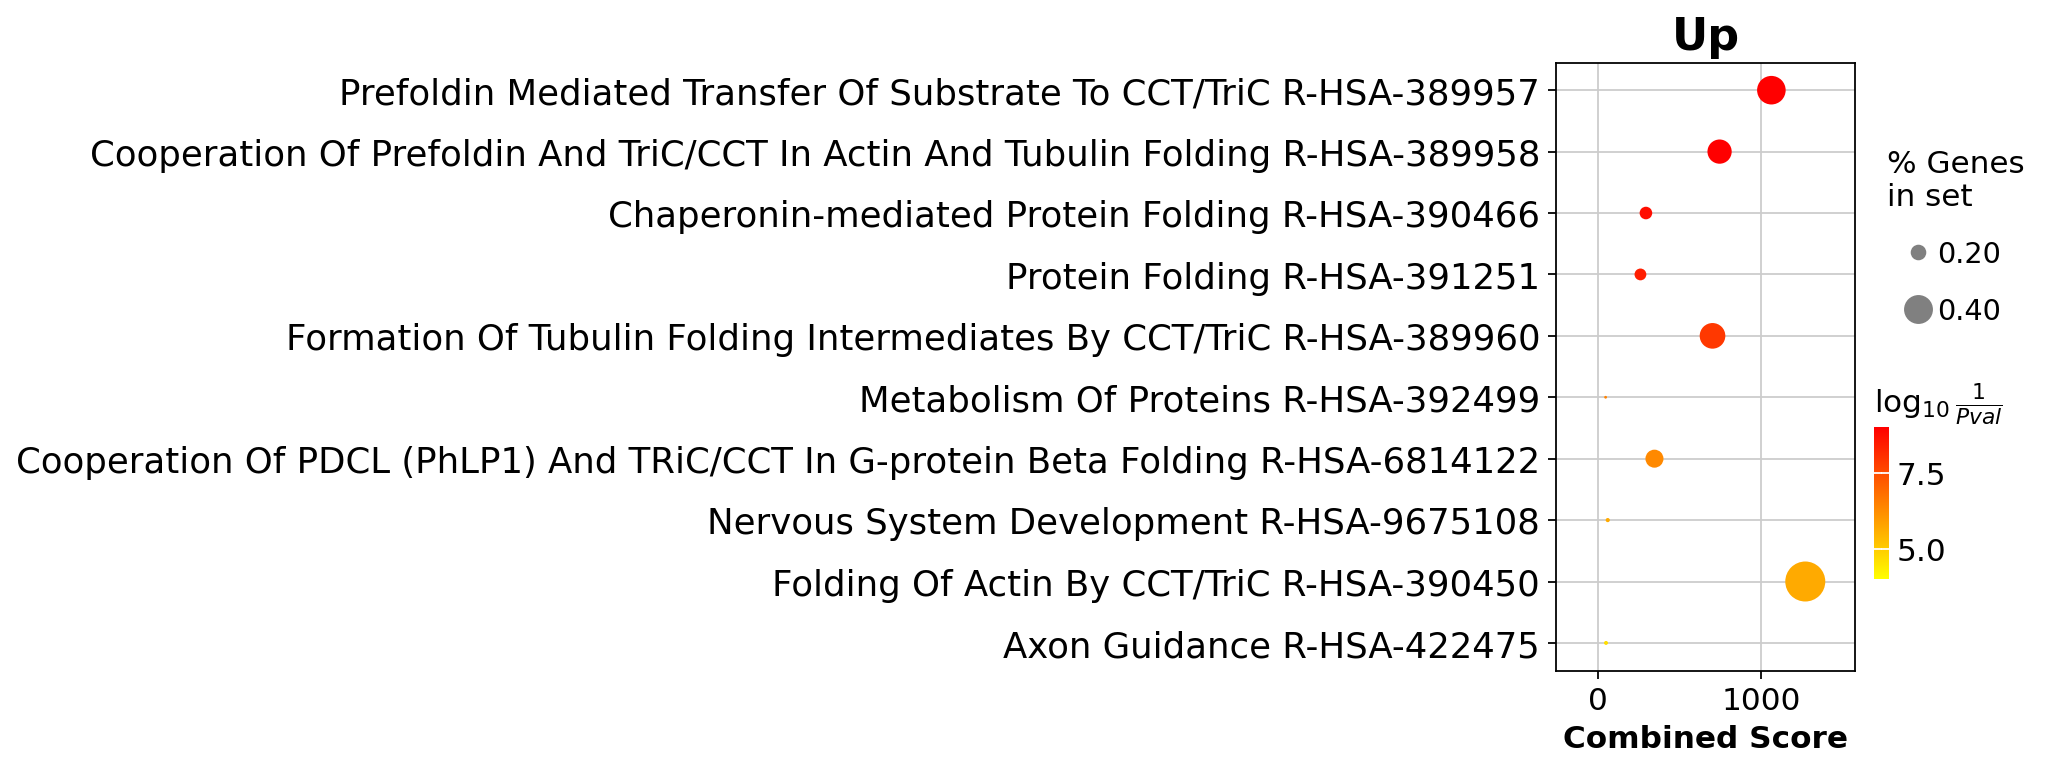

In [112]:
gseapy.dotplot(enr_res_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [113]:
enr_res_up.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_REACTOME_upreg.csv')

### Downregulated

In [114]:
enr_res_dw = gseapy.enrichr(gene_list=dwreg_genes,
                     organism='Human',
                     gene_sets='Reactome_2022')

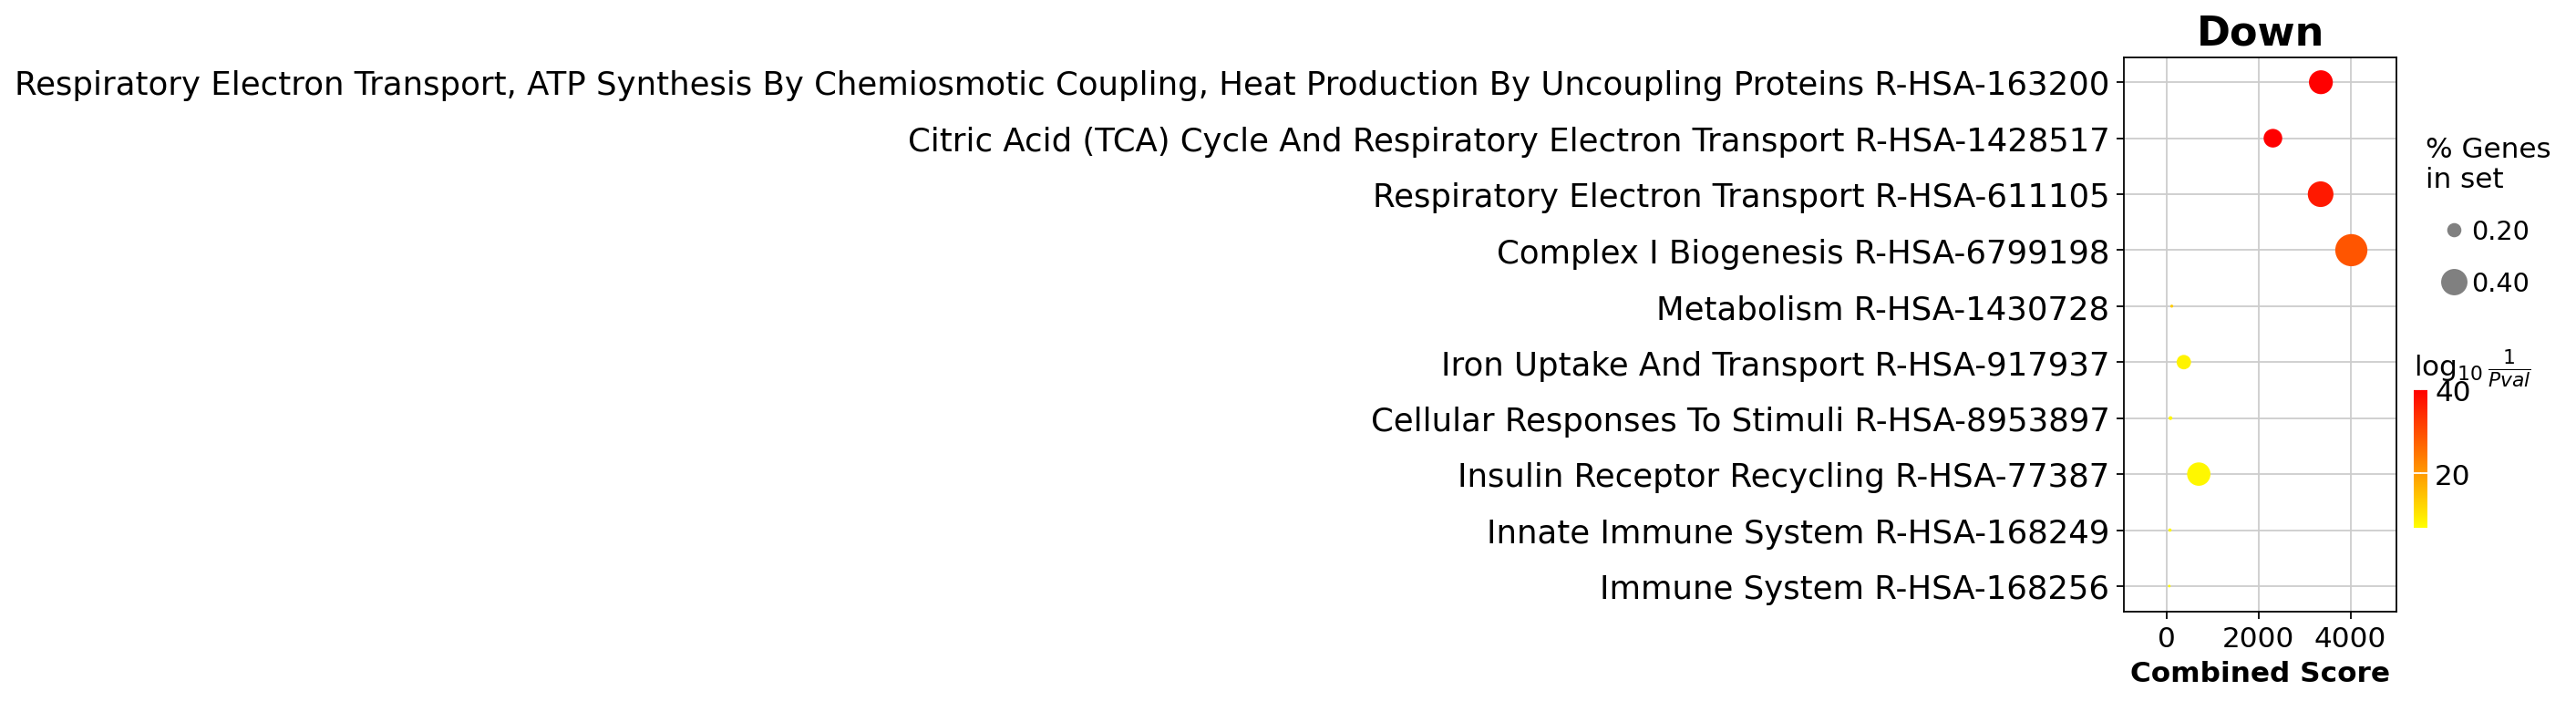

In [115]:
gseapy.dotplot(enr_res_dw.res2d, figsize=(3,5), title="Down", cmap = plt.cm.autumn_r)
plt.show()

In [116]:
enr_res_dw.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_REACTOME_dwreg.csv')

### Combined

In [117]:
enr_res_up.res2d['UP_DW'] = "UP"
enr_res_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_res_up.res2d.head(10), enr_res_dw.res2d.head(10)])

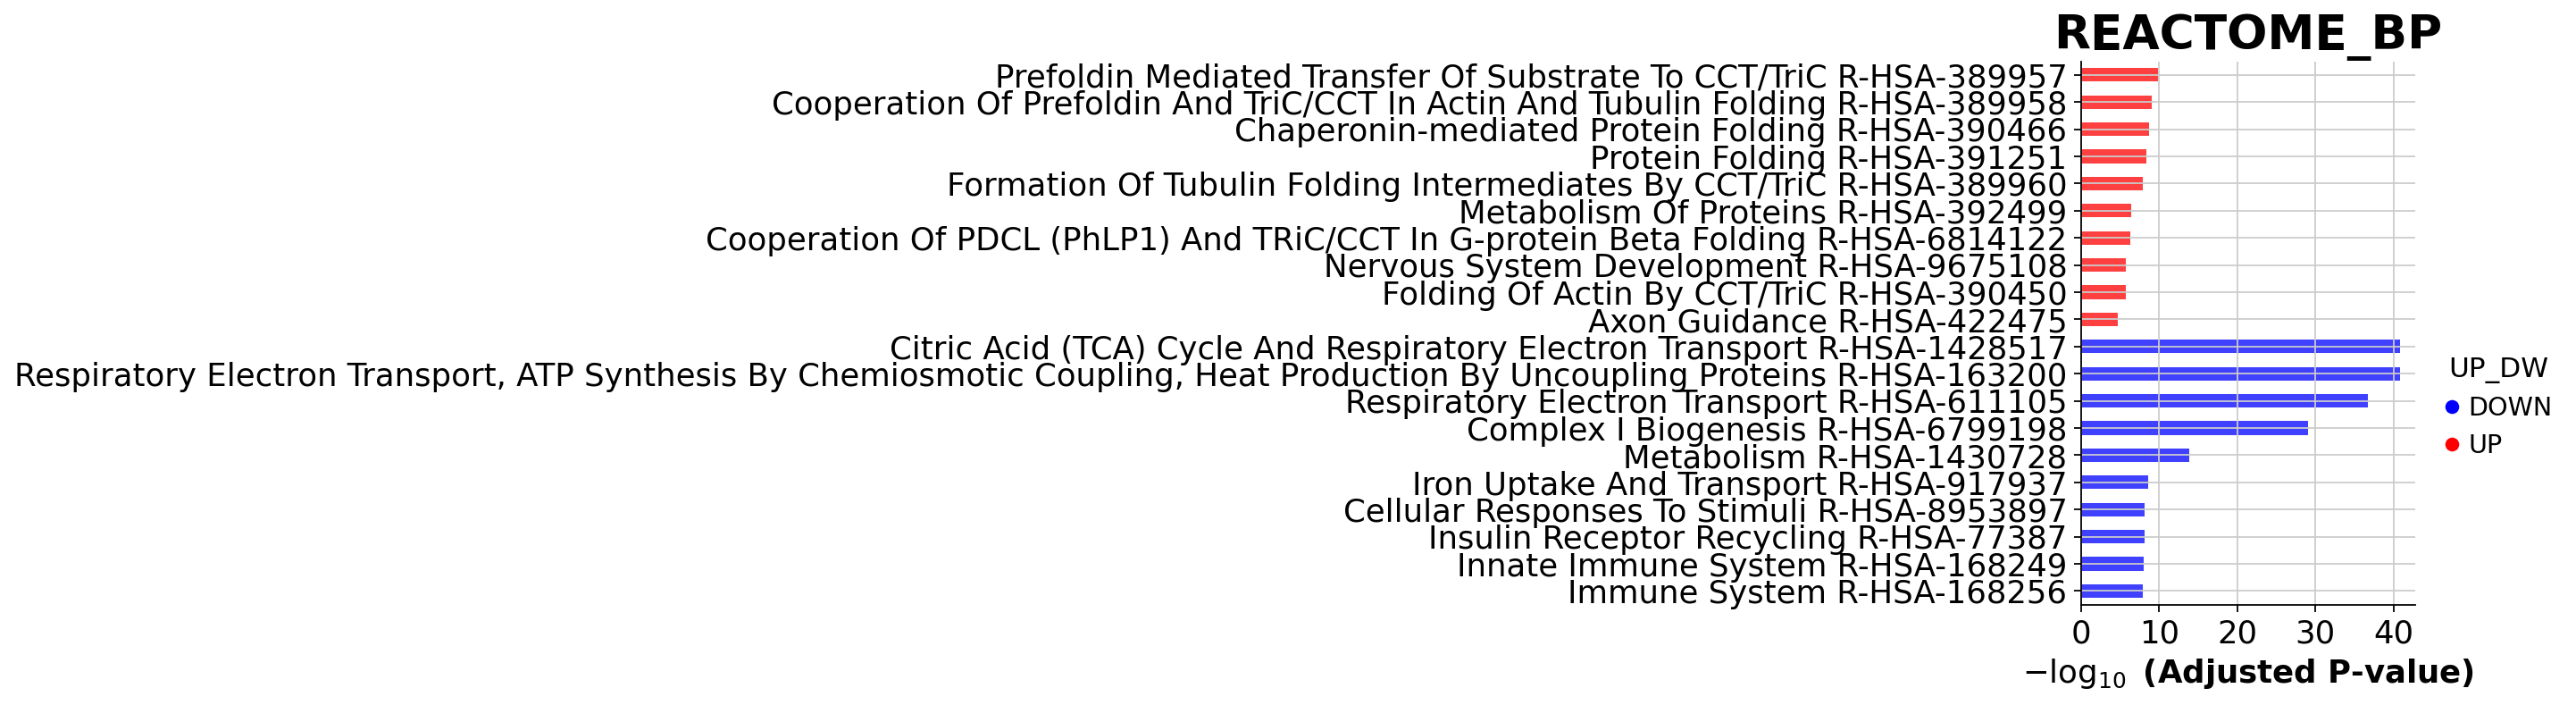

In [118]:
ax = gseapy.barplot(enr_res, figsize=(3,5),
                group ='UP_DW',
                title ="REACTOME_BP",
                color = ['b','r'],
                top_term=16)

## Возьмём базу данных `GO_Biological_Process_2021`

### Upregulated

In [ ]:
enr_res_up = gseapy.enrichr(gene_list=upreg_genes,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021')

In [ ]:
enr_res_up.res2d.Term = enr_res_up.res2d.Term.str.split(" \(GO").str[0]

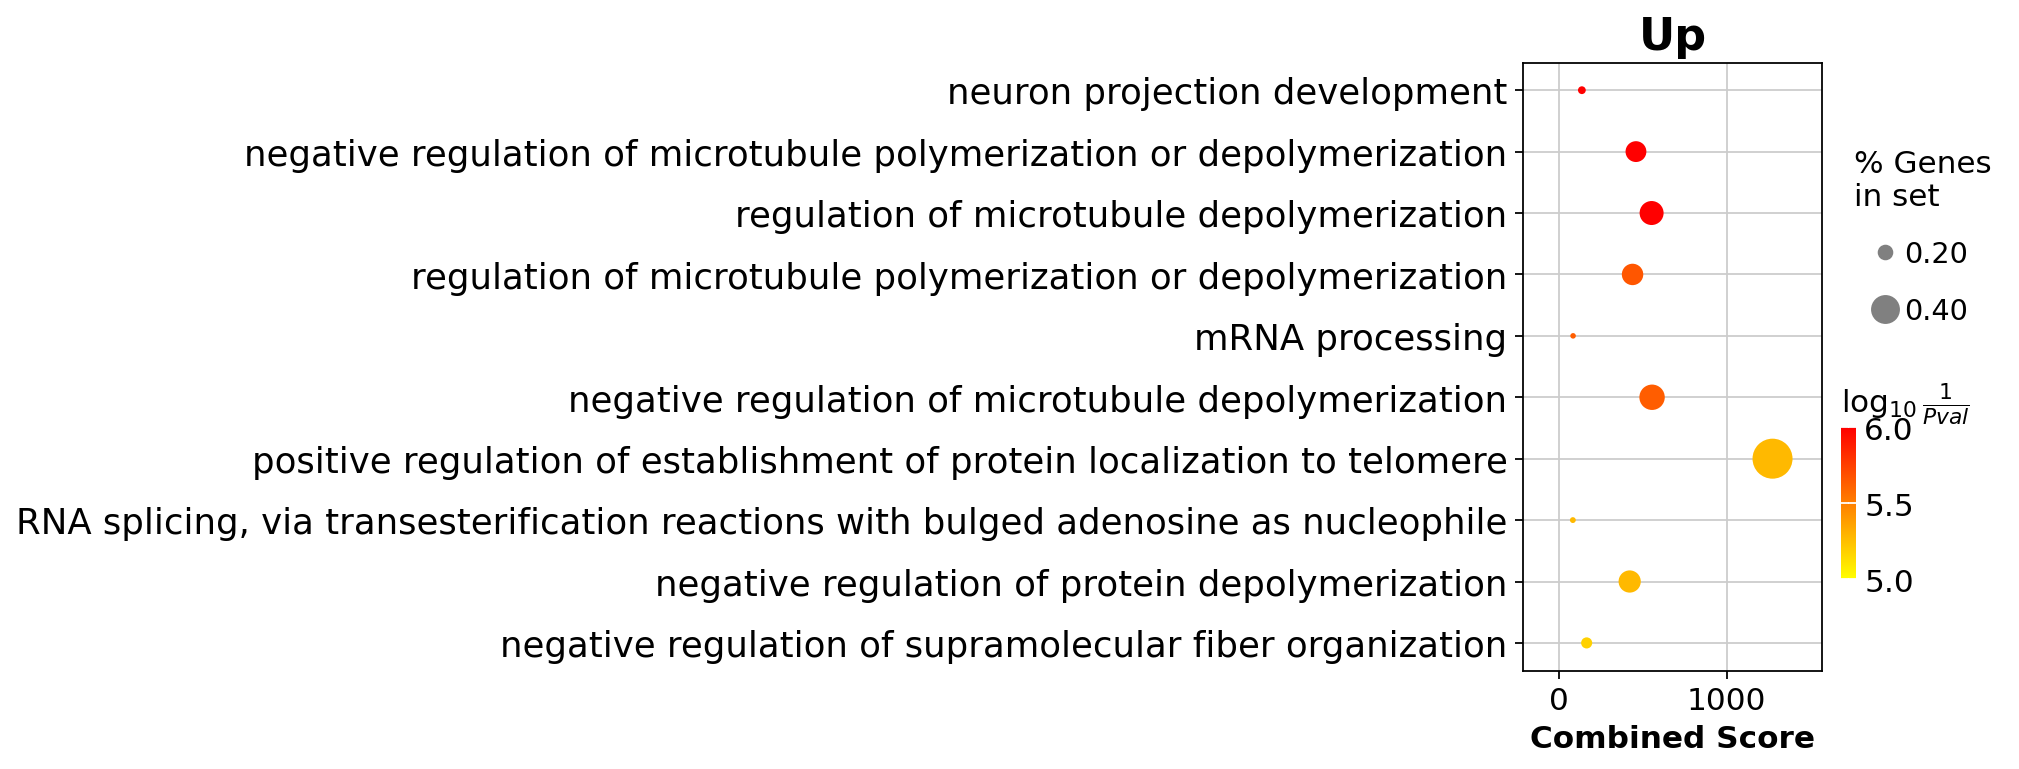

In [ ]:
gseapy.dotplot(enr_res_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [ ]:
enr_res_up.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_GO_upreg.csv')

### Downregulated

In [ ]:
enr_res_dw = gseapy.enrichr(gene_list=dwreg_genes,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021')

In [ ]:
enr_res_dw.res2d.Term = enr_res_dw.res2d.Term.str.split(" \(GO").str[0]

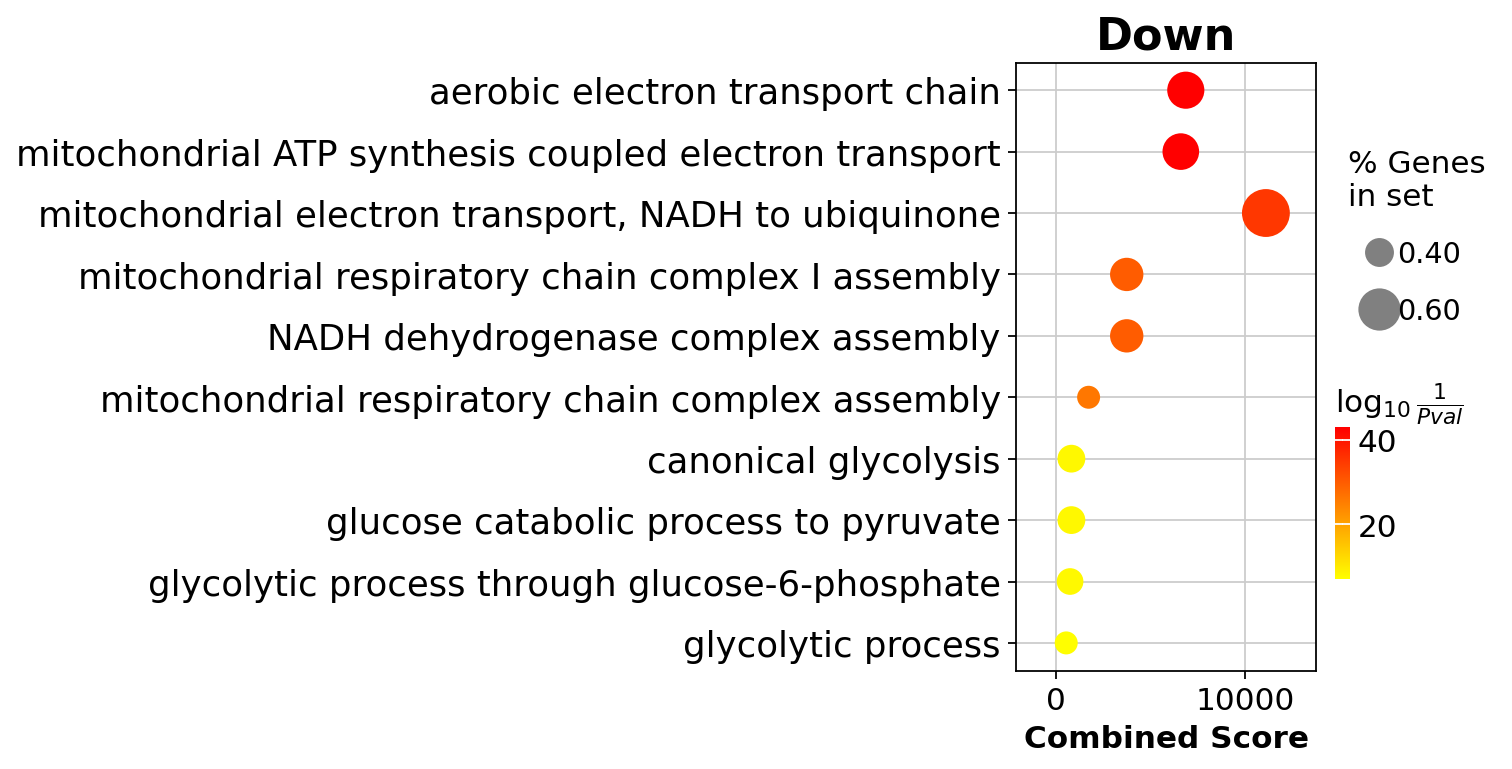

In [ ]:
gseapy.dotplot(enr_res_dw.res2d, figsize=(3,5), title="Down", cmap = plt.cm.autumn_r)
plt.show()

In [ ]:
enr_res_dw.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_GO_dwreg.csv')

### Combined

In [ ]:
enr_res_up.res2d['UP_DW'] = "UP"
enr_res_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_res_up.res2d.head(10), enr_res_dw.res2d.head(10)])

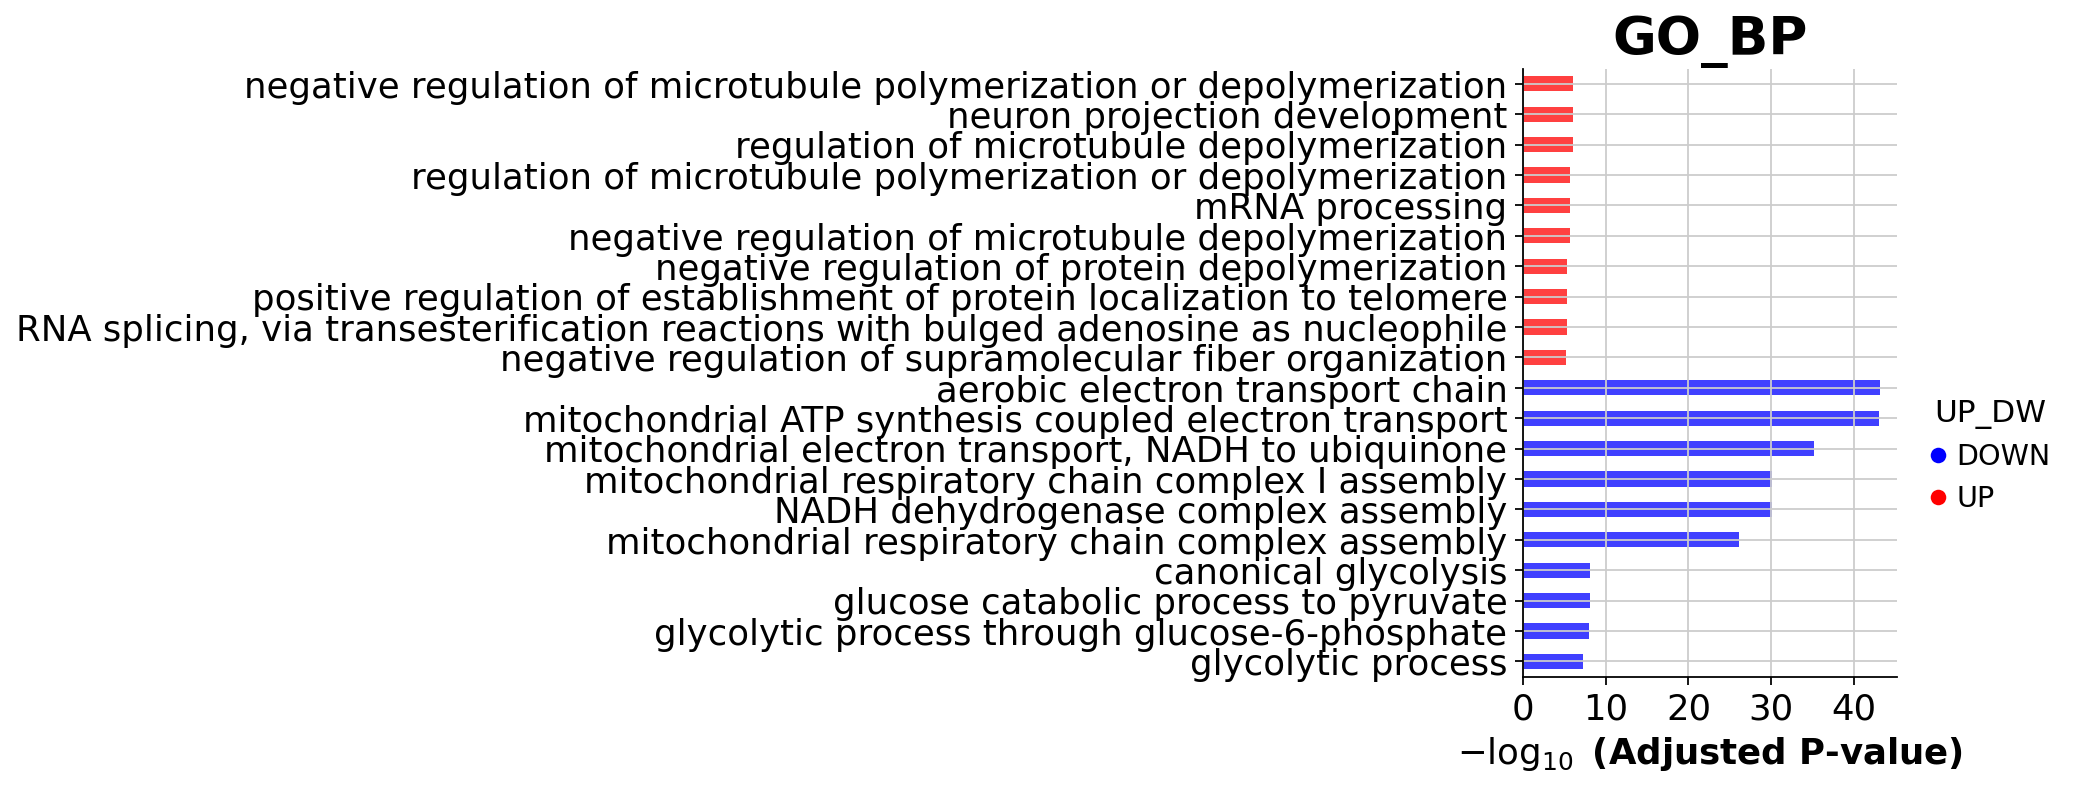

In [ ]:
ax = gseapy.barplot(enr_res, figsize=(3,5),
                group ='UP_DW',
                title ="GO_BP",
                color = ['b','r'],
                top_term=16)

## Возьмём базу данных `MGI_Mammalian_Phenotype_Level_4_2021`

### Upregulated

In [120]:
enr_res_up = gseapy.enrichr(gene_list=upreg_genes,
                     organism='Human',
                     gene_sets='MGI_Mammalian_Phenotype_Level_4_2021')

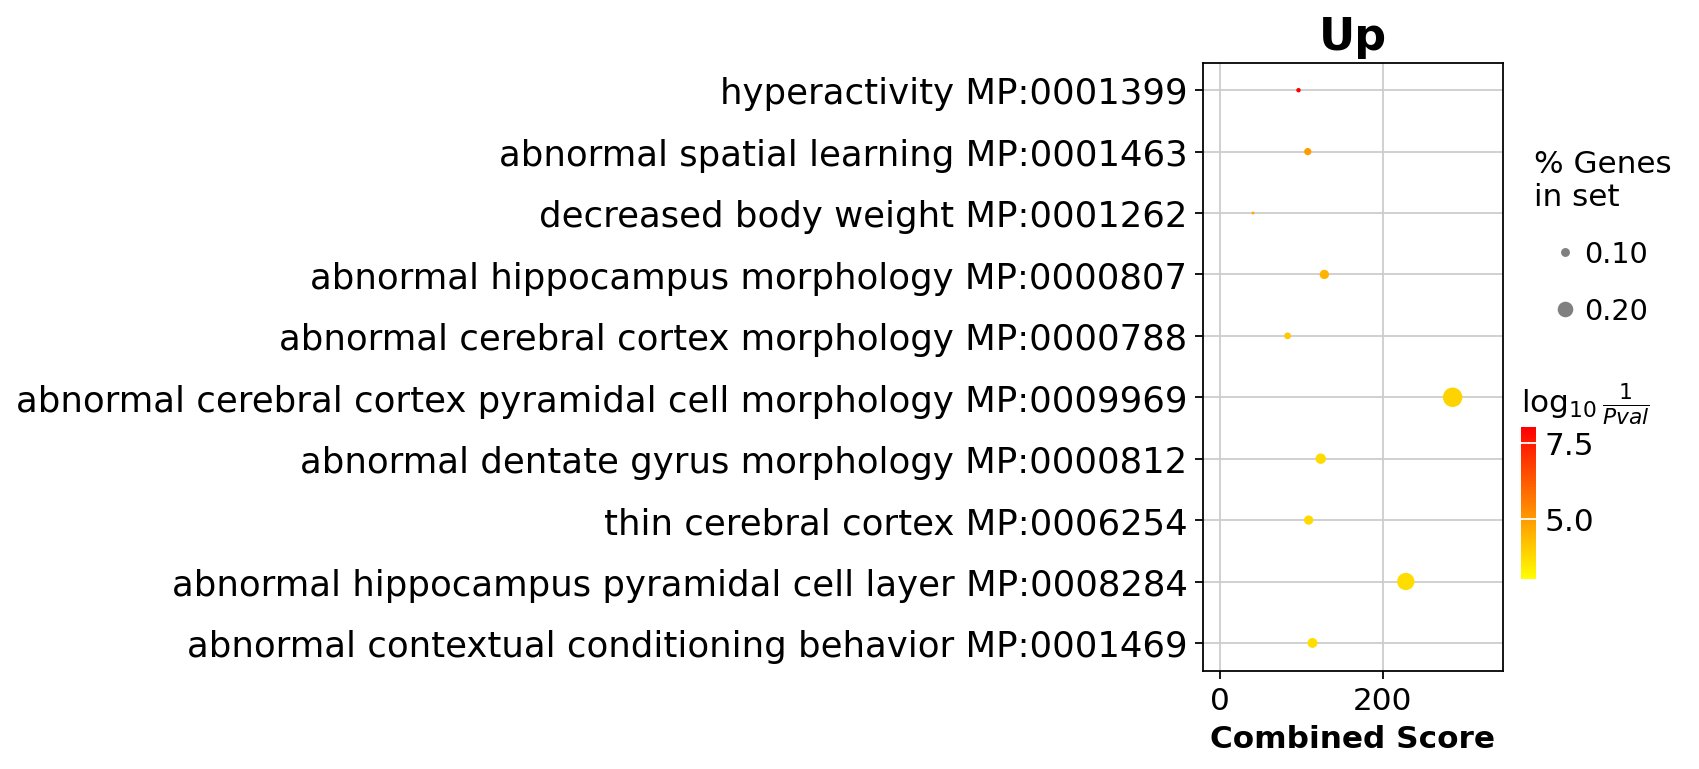

In [121]:
gseapy.dotplot(enr_res_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [122]:
enr_res_up.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_MGI_Mammalian_Phenotype_Level_4_2021_upreg.csv')

### Downregulated

In [123]:
enr_res_dw = gseapy.enrichr(gene_list=dwreg_genes,
                     organism='Human',
                     gene_sets='MGI_Mammalian_Phenotype_Level_4_2021')

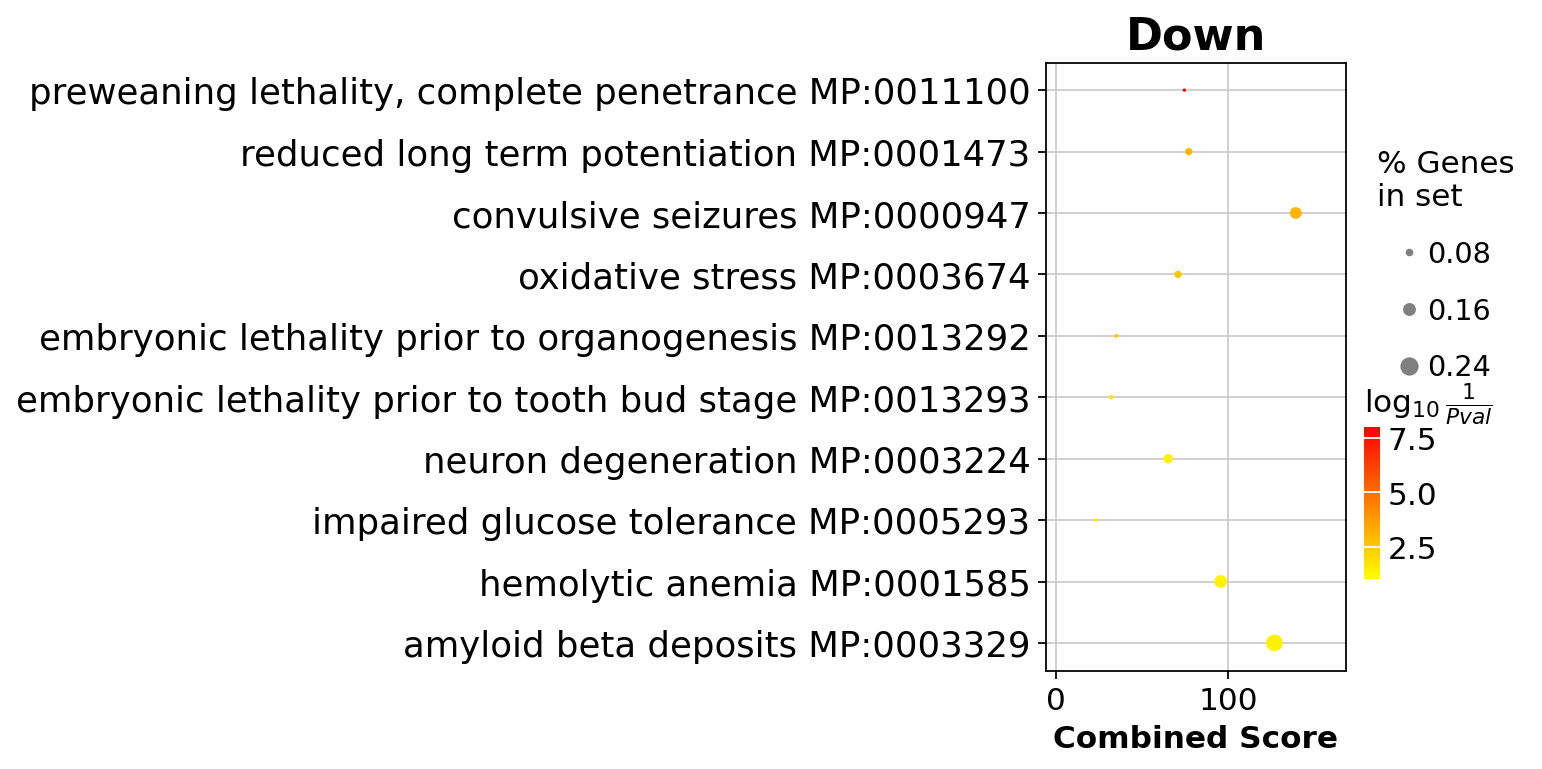

In [124]:
gseapy.dotplot(enr_res_dw.res2d, figsize=(3,5), title="Down", cmap = plt.cm.autumn_r)
plt.show()

In [125]:
enr_res_dw.res2d.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSA_MGI_Mammalian_Phenotype_Level_4_2021_dwreg.csv')

### Combined

In [126]:
enr_res_up.res2d['UP_DW'] = "UP"
enr_res_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_res_up.res2d.head(10), enr_res_dw.res2d.head(10)])

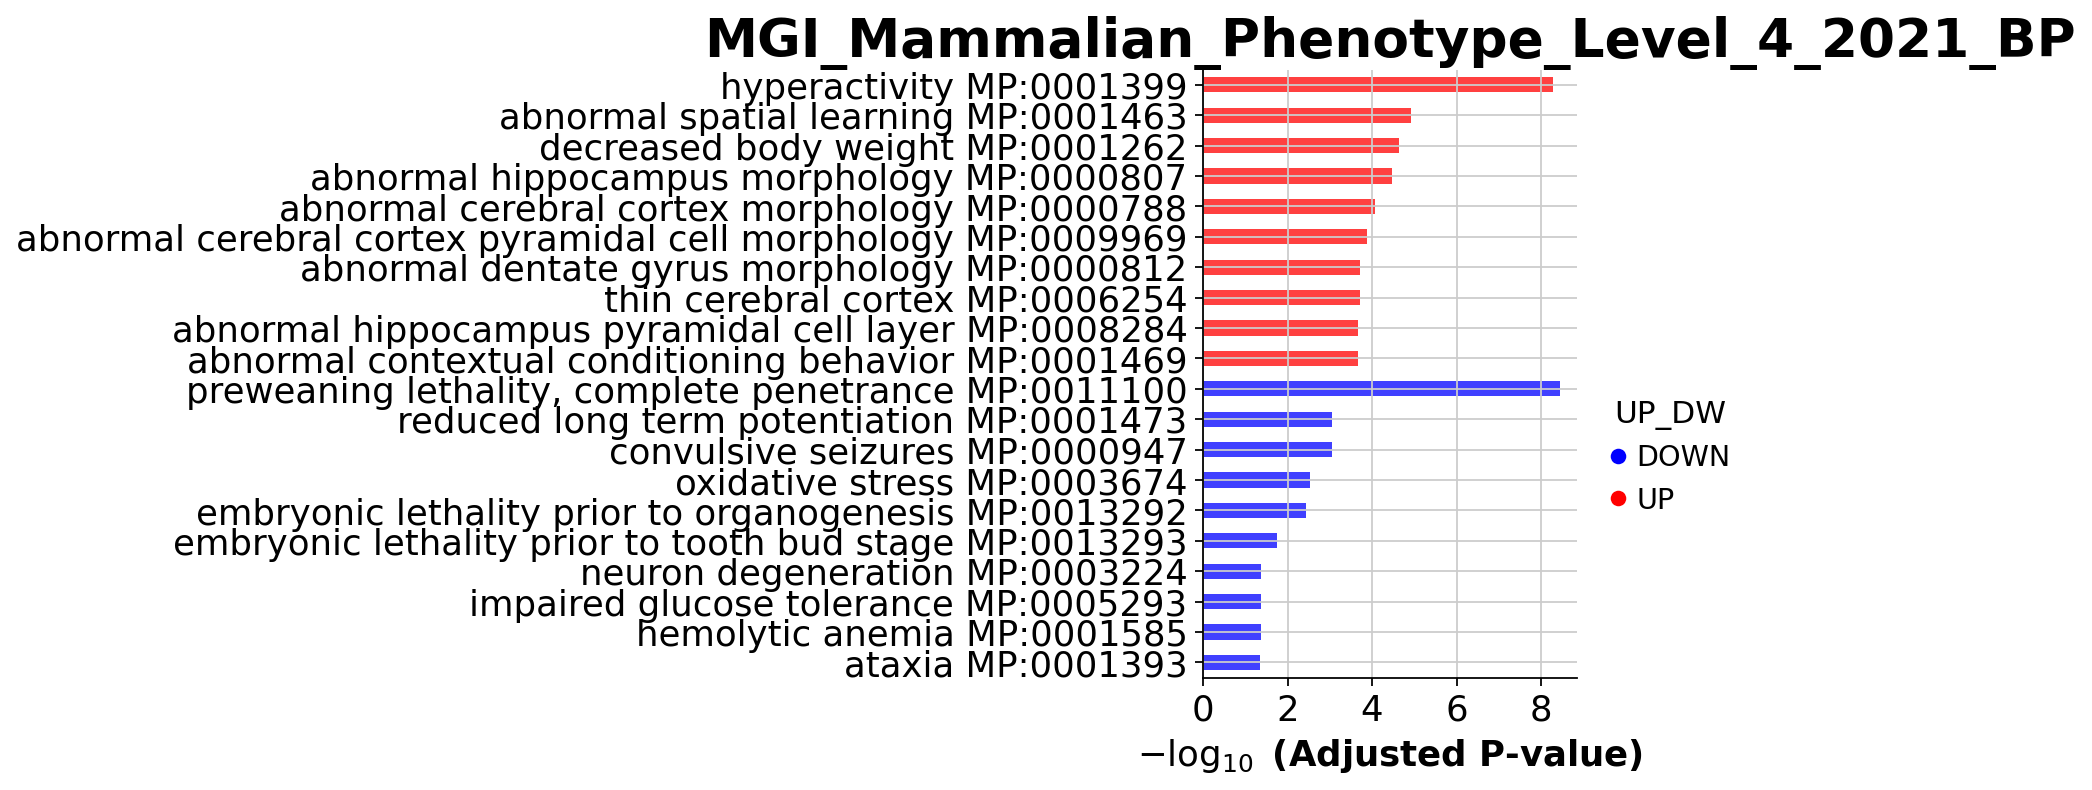

In [127]:
ax = gseapy.barplot(enr_res, figsize=(3,5),
                group ='UP_DW',
                title ="MGI_Mammalian_Phenotype_Level_4_2021_BP",
                color = ['b','r'],
                top_term=16)

# GSEA

## GO_Biological_Process_2021

In [173]:
layer = 'L3'
genes_by_fc = edgeR_sign[layer].sort_values(by='logFC', ascending=False).index.tolist()

In [174]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
genes_str = '\n'.join(genes_by_fc)
description = 'L1 gene list'
payload = {
    'list': (None, genes_str),
    'description': (None, description)
}

response = requests.post(ENRICHR_URL, files=payload)
if not response.ok:
    raise Exception('Error analyzing gene list')

data = json.loads(response.text)
print(data)

{'shortId': 'dbab1a7785db8a4ff5605ef56ced182b', 'userListId': 60475237}


In [181]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
query_string = '?userListId=%s&backgroundType=%s'
user_list_id = 60475237
gene_set_library = 'GO_Biological_Process_2021'
response = requests.get(
    ENRICHR_URL + query_string % (user_list_id, gene_set_library)
 )
if not response.ok:
    raise Exception('Error fetching enrichment results')

data = json.loads(response.text)
print(data)

{'GO_Biological_Process_2021': [[1, 'cellular protein modification process (GO:0006464)', 3.00693073897853e-21, 1.833454524715913, 86.63689968528224, ['GMFB', 'PGAP1', 'MAML1', 'GMFG', 'ARAF', 'DCAF8', 'DCAF5', 'DCAF7', 'DCAF6', 'NAA80', 'PSMD8', 'LIPE', 'PSMD9', 'NUB1', 'PPP4R1', 'PSMD7', 'PSMD4', 'AKT3', 'AKT1', 'PRKACA', 'CHGB', 'PRKCG', 'WSB1', 'CSNK2A1', 'WSB2', 'DAPK1', 'PRKCB', 'DAPK2', 'PRKCE', 'DAPK3', 'PRKCD', 'ATG10', 'PRKCA', 'PASK', 'PRKAR1B', 'PSME1', 'PSME2', 'SPARCL1', 'PRKD1', 'ALG10B', 'UBA52', 'MTMR3', 'RPN2', 'CTBP1', 'PRKDC', 'RPN1', 'COPS7A', 'ZC3HAV1', 'MTMR4', 'HIF1A', 'MTMR6', 'MTMR7', 'C3', 'HLCS', 'ST3GAL5', 'PSMF1', 'ATG7', 'ST3GAL1', 'ST3GAL2', 'LHPP', 'B3GALNT2', 'PRRT1', 'CDK17', 'B3GALNT1', 'CDK18', 'CDK19', 'ICMT', 'DMPK', 'PLK2', 'EIF2AK2', 'ABCA7', 'BRAF', 'EIF2AK4', 'FAM220A', 'MEX3B', 'PPP5C', 'GALNTL5', 'CDK13', 'CDK14', 'RET', 'ARF4', 'PIGU', 'PIGT', 'SETD3', 'HIF3A', 'WDR45', 'PRSS23', 'TRIOBP', 'DDA1', 'IKBKB', 'UBL5', 'B3GALT2', 'TIMP1', 'JAK2'

In [182]:
columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
results = pd.DataFrame(data['GO_Biological_Process_2021'], columns=columns)
results.Term = results.Term.astype(str)
results.set_index('Rank')
results.head(3)

Rank                                               Term         p-val  \
0     1  cellular protein modification process (GO:0006...  3.006931e-21   
1     2  negative regulation of transcription, DNA-temp...  1.580195e-13   
2     3        mRNA splicing, via spliceosome (GO:0000398)  2.974698e-13   

    Z-score  Combined score  \
0  1.833455       86.636900   
1  1.629391       48.028021   
2  2.448826       70.632623   

                                   Overlapping genes  Adjusted P-value  \
0  [GMFB, PGAP1, MAML1, GMFG, ARAF, DCAF8, DCAF5,...      1.786418e-17   
1  [ZNF175, SPI1, MYT1L, EHMT2, EHMT1, HNRNPU, EN...      4.693970e-10   
2  [DBR1, GEMIN2, EIF4A3, GPATCH1, HNRNPU, HNRNPR...      5.890894e-10   

   Old p-value  Old adjusted p-value  
0            0                     0  
1            0                     0  
2            0                     0

<Axes: xlabel='Adjusted P-value', ylabel='Term'>

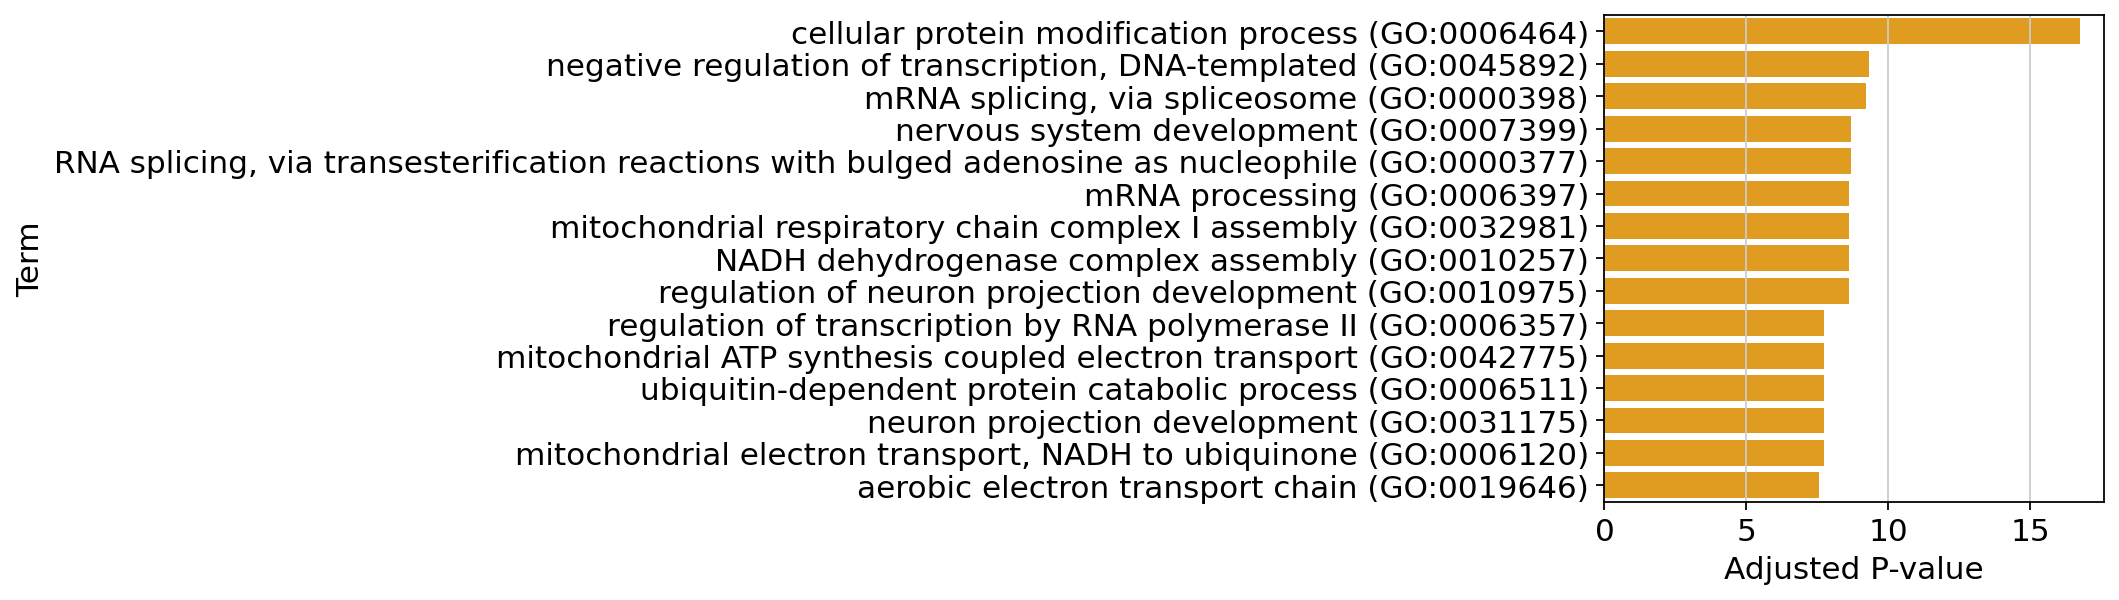

In [183]:
n_top = 15
sns.barplot(data=results.iloc[:n_top], x=-np.log10(results['Adjusted P-value']), y='Term', color='orange')

In [178]:
results.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSEA_GO_Biological_Process_2021.csv')

## Reactome_2022

In [179]:
layer = 'L3'
genes_by_fc = edgeR_sign[layer].sort_values(by='logFC', ascending=False).index.tolist()

In [180]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
genes_str = '\n'.join(genes_by_fc)
description = 'L1 gene list'
payload = {
    'list': (None, genes_str),
    'description': (None, description)
}

response = requests.post(ENRICHR_URL, files=payload)
if not response.ok:
    raise Exception('Error analyzing gene list')

data = json.loads(response.text)
print(data)

{'shortId': '3705f5013d5b27f9da205f22421f733d', 'userListId': 60475250}


In [184]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
query_string = '?userListId=%s&backgroundType=%s'
user_list_id = 60475250
gene_set_library = 'Reactome_2022'
response = requests.get(
    ENRICHR_URL + query_string % (user_list_id, gene_set_library)
 )
if not response.ok:
    raise Exception('Error fetching enrichment results')

data = json.loads(response.text)
print(data)

{'Reactome_2022': [[1, 'Gene Expression (Transcription) R-HSA-74160', 2.3022339829066552e-23, 1.720271022603416, 89.6701199771496, ['TDRKH', 'NUP107', 'SPI1', 'EHMT2', 'EHMT1', 'PSMD8', 'PSMD9', 'LSM11', 'PSMD7', 'PSMD4', 'AKT3', 'AKT1', 'MTERF1', 'ZNF287', 'DAXX', 'MEF2C', 'PRKAB2', 'RBFOX1', 'SAP30BP', 'ZNF282', 'ZNF10', 'DICER1', 'ZNF14', 'CLDN5', 'SCO2', 'DDIT3', 'DDIT4', 'PSME1', 'PSME2', 'TXNIP', 'MYL9', 'ZNF28', 'SLBP', 'ZNF274', 'GATA3', 'ZNF25', 'ZNF26', 'GRIN2A', 'PSMF1', 'ATRIP', 'PPARGC1A', 'ZNF268', 'PPARGC1B', 'PRELID3A', 'ZNF266', 'CREBBP', 'ZNF263', 'JAG1', 'NR2F1', 'ZNF34', 'MAGOHB', 'GRIN2B', 'NR2F6', 'COL1A1', 'MOV10', 'COL1A2', 'AGO3', 'AGO4', 'ZNF30', 'ZNF254', 'ZNF253', 'ZNF493', 'ZNF250', 'ZNF43', 'ZNF45', 'BBC3', 'MED17', 'MECP2', 'MED14', 'MED13', 'HEY1', 'MED10', 'ZNF41', 'NELFB', 'NELFA', 'ZNF483', 'CNOT6L', 'ACTL6B', 'RING1', 'RMI1', 'ZNF480', 'BAZ1B', 'MED26', 'SIRT1', 'DDB2', 'MED23', 'PSMA5', 'PSMA6', 'MED24', 'PSMA4', 'PSMA2', 'MED20', 'PPARD', 'ZNF473',

In [186]:
columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
results = pd.DataFrame(data['Reactome_2022'], columns=columns)
results.Term = results.Term.astype(str)
results.set_index('Rank')
results.head(3)

Rank                                               Term         p-val  \
0     1        Gene Expression (Transcription) R-HSA-74160  2.302234e-23   
1     2        RNA Polymerase II Transcription R-HSA-73857  6.972921e-20   
2     3  Post-translational Protein Modification R-HSA-...  3.098487e-18   

    Z-score  Combined score  \
0  1.720271       89.670120   
1  1.682039       74.194163   
2  1.622045       65.393764   

                                   Overlapping genes  Adjusted P-value  \
0  [TDRKH, NUP107, SPI1, EHMT2, EHMT1, PSMD8, PSM...      4.118697e-20   
1  [ZNF175, SPI1, MAML1, EHMT2, EHMT1, PHAX, PSMD...      6.237278e-17   
2  [NUP107, PGAP1, TRRAP, DCAF8, SMC5, SMC6, DCAF...      1.847731e-15   

   Old p-value  Old adjusted p-value  
0            0                     0  
1            0                     0  
2            0                     0

<Axes: xlabel='Adjusted P-value', ylabel='Term'>

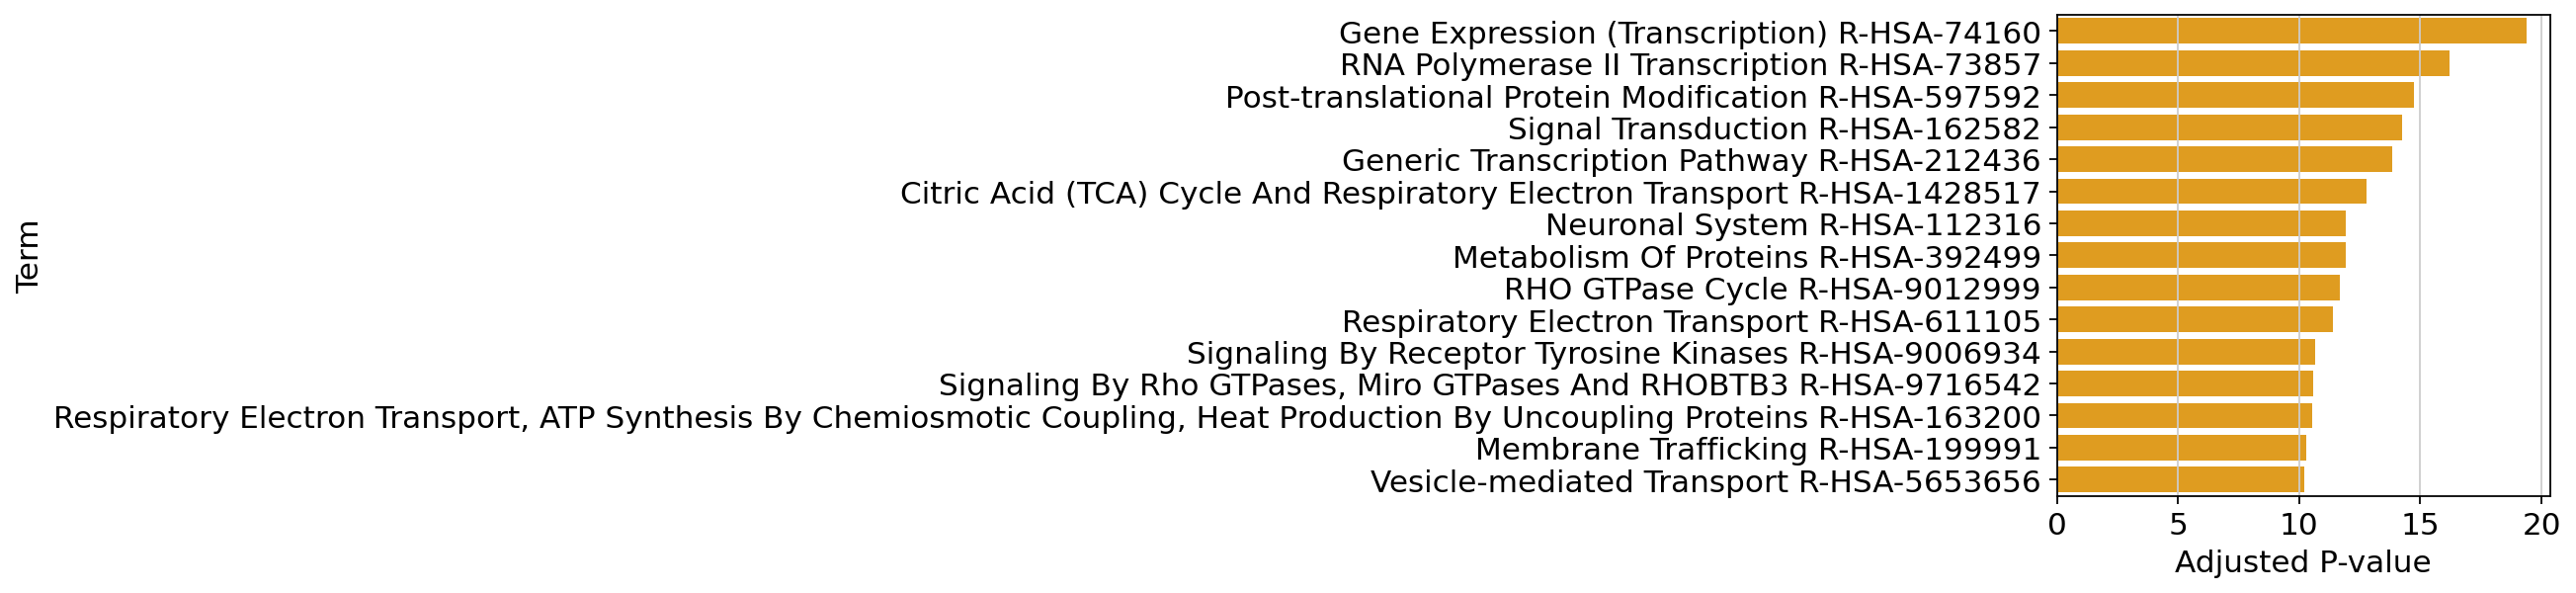

In [187]:
n_top = 15
sns.barplot(data=results.iloc[:n_top], x=-np.log10(results['Adjusted P-value']), y='Term', color='orange')

In [188]:
results.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSEA_Reactome_2022.csv')

## MGI_Mammalian_Phenotype_Level_4_2021

In [189]:
layer = 'L3'
genes_by_fc = edgeR_sign[layer].sort_values(by='logFC', ascending=False).index.tolist()

In [190]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
genes_str = '\n'.join(genes_by_fc)
description = 'L3 gene list'
payload = {
    'list': (None, genes_str),
    'description': (None, description)
}

response = requests.post(ENRICHR_URL, files=payload)
if not response.ok:
    raise Exception('Error analyzing gene list')

data = json.loads(response.text)
print(data)

{'shortId': '57bfc79408b76b01662ec5c979876b0c', 'userListId': 60475266}


In [191]:
import json
import requests


ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
query_string = '?userListId=%s&backgroundType=%s'
user_list_id = 60475266
gene_set_library = 'MGI_Mammalian_Phenotype_Level_4_2021'
response = requests.get(
    ENRICHR_URL + query_string % (user_list_id, gene_set_library)
 )
if not response.ok:
    raise Exception('Error fetching enrichment results')

data = json.loads(response.text)
print(data)

{'MGI_Mammalian_Phenotype_Level_4_2021': [[1, 'preweaning lethality, complete penetrance MP:0011100', 3.870527260752361e-37, 2.0106215906889315, 168.57505354358412, ['ATF2', 'PGAP1', 'SPI1', 'EHMT2', 'POP4', 'EHMT1', 'SCAMP5', 'KIAA1109', 'MPRIP', 'ALKBH1', 'FGFR1OP2', 'ANKFY1', 'DAXX', 'RBFOX1', 'CXADR', 'SECISBP2', 'ZNF281', 'DNTTIP1', 'FRS2', 'DICER1', 'MTHFD1', 'SPINT1', 'RUFY3', 'CDIP1', 'JTB', 'SLBP', 'SHMT2', 'CDCA5', 'MRPL12', 'LARP1', 'HLCS', 'FIGNL1', 'PIP5K1C', 'PSMF1', 'RSU1', 'ATG7', 'ATRIP', 'RHBDL1', 'B3GALNT2', 'JAG2', 'PRPF38B', 'JUP', 'ZNF260', 'NR2F1', 'PBX3', 'CS', 'MLLT10', 'COL1A2', 'VANGL2', 'ARF4', 'PIGU', 'PIGT', 'PIGO', 'PIGQ', 'PTH1R', 'OSBPL11', 'MRPL33', 'MED11', 'CHAF1B', 'TUBA1A', 'MED10', 'IKBKG', 'NELFA', 'SLC39A10', 'SRP9', 'MED28', 'MRPL44', 'MED23', 'PIGC', 'SLC7A5', 'MRPL51', 'CINP', 'MED20', 'RAPGEF1', 'PIGM', 'ZNF236', 'PIGF', 'PIGH', 'CRB2', 'TRUB2', 'ELOF1', 'SYNPO2', 'URM1', 'ATL2', 'ODC1', 'HTT', 'TMEM70', 'RECQL4', 'NRAS', 'TMEM67', 'LEO1', '

In [192]:
columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
results = pd.DataFrame(data['MGI_Mammalian_Phenotype_Level_4_2021'], columns=columns)
results.Term = results.Term.astype(str)
results.set_index('Rank')
results.head(3)

Rank                                               Term         p-val  \
0     1  preweaning lethality, complete penetrance MP:0...  3.870527e-37   
1     2                           hyperactivity MP:0001399  5.036470e-26   
2     3                   decreased body weight MP:0001262  1.479196e-20   

    Z-score  Combined score  \
0  2.010622      168.575054   
1  2.256490      131.441679   
2  1.692945       77.300204   

                                   Overlapping genes  Adjusted P-value  \
0  [ATF2, PGAP1, SPI1, EHMT2, POP4, EHMT1, SCAMP5...      1.762251e-33   
1  [CYFIP2, ATF2, EHMT1, BACH2, PREX2, SCAMP5, GP...      1.146552e-22   
2  [ATF2, MAML1, ITSN1, ARAF, SMC6, SMC3, SLC4A4,...      2.244926e-17   

   Old p-value  Old adjusted p-value  
0            0                     0  
1            0                     0  
2            0                     0

<Axes: xlabel='Adjusted P-value', ylabel='Term'>

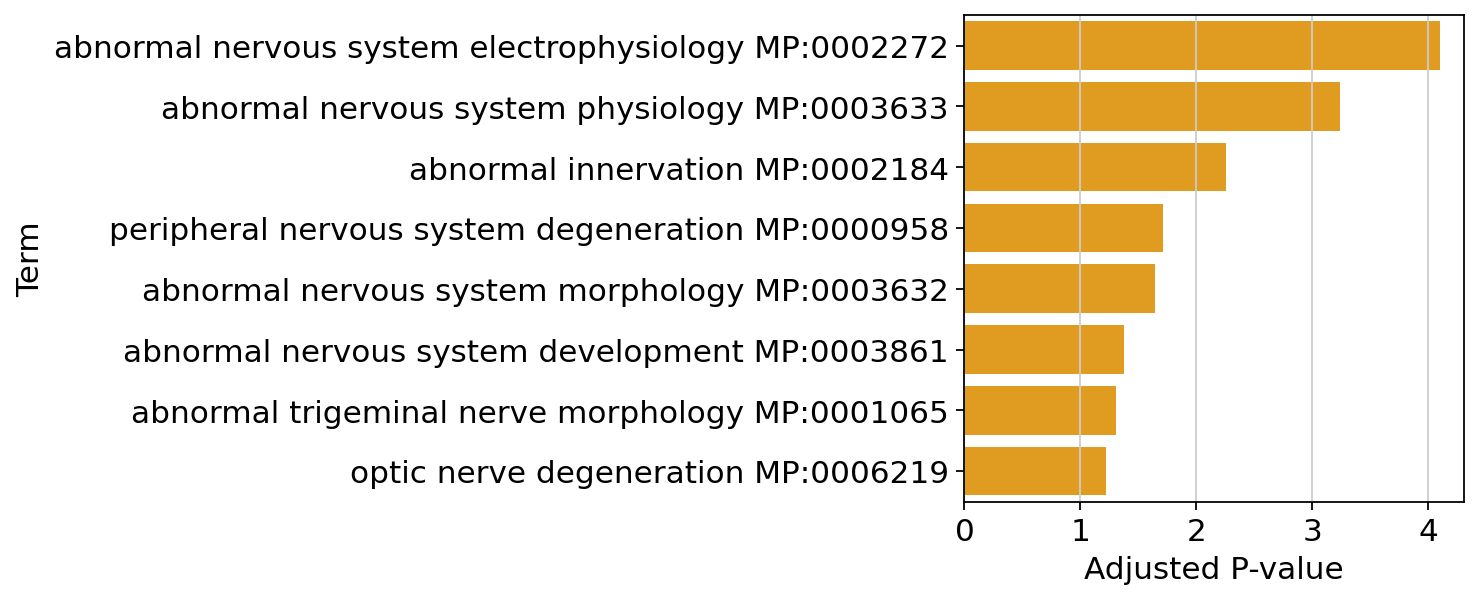

In [200]:
n_top = 8
sns.barplot(data=results[results.Term.str.contains('nerv')].iloc[:n_top], x=-np.log10(results['Adjusted P-value']), y='Term', color='orange')

In [201]:
results.to_csv(f'drive/MyDrive/Spatial project/results/Functional_analysis/pseudobulks/GSEA_MGI_Mammalian_Phenotype_Level_4_2021.csv')